# Zastosowanie wielomianów ortogonalnych w medycynie obliczeniowej
#### Autor: dr inż. Katarzyna Rycerz

## Wielomiany ortogonalne - teoria

W przestrzeni wielomianów rzeczywistych dowolnego stopnia określonych na przedziale $[a,b]$ możemy wprowadzić następującą definicję iloczynu skalarnego:

$$\langle P_n,P_m\rangle=\int_a^b P_n(x)P_m(x)\omega(x)dx$$

gdzie funkcja $\omega$ jest nazywana *funkcją wagową* lub po prostu *wagą*.

Normą pochodzącą od tego iloczynu skalarnego jest

$$\|P_n\|=\sqrt{\langle P_n,P_n\rangle}=\left(\int_a^b P_n^2(x)\omega(x)dx\right)^{\frac{1}{2}}$$

**Wielomiany ortogonalne** to rodzina wielomianów, w których iloczyn skalarny dwóch różnych wielomianów jest równy 0.

Jeżeli dodatkowo norma każdego wielomianu (czyli jego iloczyn skalarny przez siebie) jest równa 1, to nazywamy je **wielomianami ortonormalnymi.**

### Przykładowe rodziny wielomianów ortogonalnych

| Nazwa                | Przedział       | Funkcja wagowa           | Zastosowanie                                           | Parzystość                                                     |
|----------------------|-----------------|--------------------------|--------------------------------------------------------|----------------------------------------------------------------|
| Czebyszewa (1 rzędu) | [-1,1]          | $\frac{1}{\sqrt{1-x^2}}$ | Zera wielomianu jako węzły interpolacji wielomianowej  | Dla parzystego k - parzyste, dla nieparzystego k - nieparzyste |
| Legendre             | [-1,1]          | 1                        | Zera wielomianu jako węzły kwadratur Gaussa-Legendre'a | jw                                                             |
| Hermite              | [$-\infty$,$\infty$] | $\exp(-x^2)$             | Zera wielomianu jako węzły kwadratur Gaussa-Hermite'a  | jw                                                             |
| Laguerre             | [0,$\infty$]      | $\exp(-x)$               | Zera wielomianu jako węzły kwadratur Gaussa-Laguerra'a | brak                                                           |


### Wielomiany Hermite'a

Zdefiniowane są rekurencyjnie jako:
$$\begin{aligned}H_0(x) &= 1\\H_1(x) &= 2x\\H_{n+1}(x) &= 2xH_n(x)-2nH_{n-1}\end{aligned}$$
albo wzorem Rodriguesa: 
$$H_{n}(x)=(-1)^{n}e^{x^{2}}{\frac {d^{n}}{dx^{n}}}e^{-x^{2}}.$$

W `scipy` wielomiany Hermite'a znajdziemy w bibliotece `special`: `scipy.special.hermite(n, monic=False)`, gdzie `n` to żądany stopień wielomianu. W przypadku `monic=True` otrzymany wielomian zostanie przeskalowany tak, aby współczynnik wiodący (przy najwyższej potędze) był równy 1. Obiektem zwracanym jest wielomian specjalnej klasy `orthopoly1d`, którego używamy jak normalnego wielomianu `poly1d`.

Wykres przykładowego wielomianu (tutaj 3 stopnia)

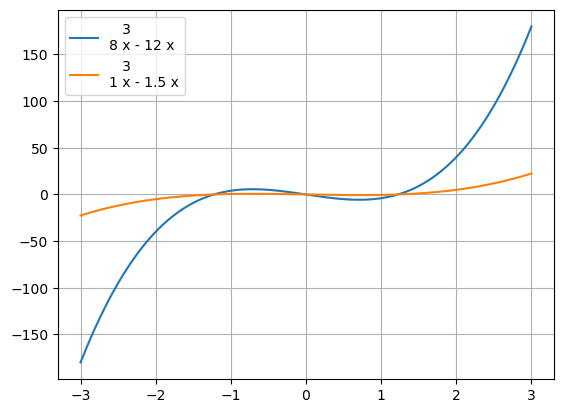

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import special

p_herm = special.hermite(3)
p_monic = special.hermite(3, monic=True)


x = np.linspace(-3, 3, 400)


plt.plot(x, p_herm(x))
plt.plot(x,p_monic(x))
plt.legend([p_herm,p_monic])
plt.grid()
plt.show()

W bibliotece `numpy` również mamy moduł dla wielomianów Hermite'a.

0.0 + 0.0·H₁(x) + 0.0·H₂(x) + 1.0·H₃(x)
[  0. -12.   0.   8.]


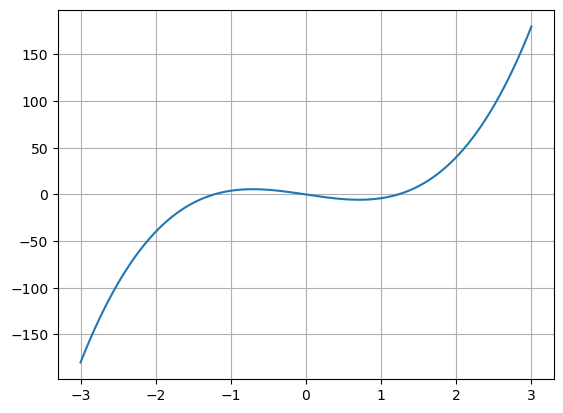

In [2]:
from numpy.polynomial import hermite
from numpy.polynomial.polynomial import Polynomial

x = np.linspace(-3, 3, 400)

HS3=hermite.Hermite([0,0,0,1]) #współczynniki szeregu Hermite'a, od wyrazu wolnego
print(HS3)

H3=hermite.herm2poly([0,0,0,1]) #postać wielomianowa otrzymanego szeregu Hermite'a,
                                #czyli wielomian Hermitte'a stopnia 3
print(H3)

plt.plot(x, Polynomial(H3)(x))
plt.grid()
plt.show()

### Przykład aproksymacji

Spróbujemy dokonać aproksymacji zaszumionej funkcji `cos` wykorzystując rodzinę zortogonalizowanych wielomianów Hermite'a.

In [3]:
# Definicja węzłów - zaszumiony cosinus
xx = np.arange(-5,5,0.1)
yy = np.cos(xx/3 + .2)**2 + np.random.rand(len(xx))/5

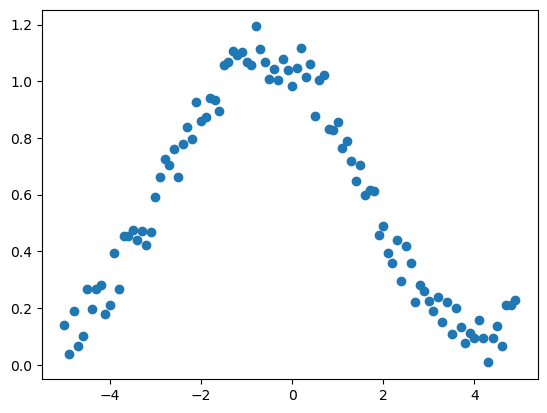

In [4]:
plt.scatter(xx, yy)

Przypomnijmy zwykłą aproksymację hermitowską z `numpy`:

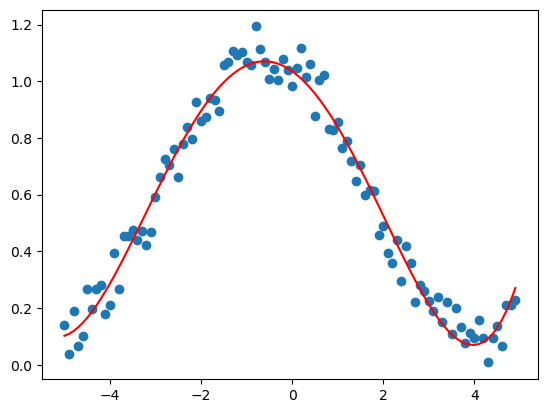

In [5]:
HFS4=hermite.hermfit(xx,yy,4)  #znalezienie współczynników szeregu Hermite'a

HF4=hermite.herm2poly(HFS4)  #postać wielomianowa otrzymanego szeregu

plt.scatter(xx, yy)
plt.plot(xx, Polynomial(HF4)(xx),'r')

plt.show()

Otrzymana aproksymacja korzysta z rozwinięcia funkcji w *szereg Hermite'a*
$$f(x)\sim\sum_{k=0}^\infty a_kH_k(x).$$

Jeżeli z kolei zortogonalizujemy rodzinę wielomianów $\{H_0,H_1,...\}$ do rodziny ortogonalnej $\{h_0,h_1,...\}$, to możemy aproksymować funkcję $f$ jej *rzutem ortogonalnym* na przestrzeń rozpiętą przez bazę $\{h_0,h_1,...\}$:
$$f(x)\sim\sum_{k=0}^\infty \frac{\langle f(x),h_k(x)\rangle}{\langle h_k,h_k\rangle}h_k(x).$$

### Algorytm aproksymacji rodziną ortogonalną krok po kroku

#### Krok 1.

* 0bliczamy funkcję bazową uwzględniającą funkcję wagową $\exp(-x^2)$.
$$\langle H_n,H_m\rangle=\int_{-\infty}^{\infty} H_n(x)H_m(x)\exp(-x^2)dx 
= \int_{-\infty}^{\infty}\underbrace{H_n(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_n}\underbrace{H_m(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_m}$$

* Wyliczamy jej wartości dla podanych punktów x
* Otrzymany wektor wartości normalizujemy, tzn. dzielimy współczynniki przez jego długość w normie Euklidesowej.


In [6]:
#przykład prostego wektora, który znormalizujemy
vec = np.array([2,2,2,2])
vec

array([2, 2, 2, 2])

In [7]:
# norma wektora
norm = np.linalg.norm(vec)
norm

4.0

In [8]:
# normalizacja - dzielimy przez normę
vec=vec/norm
vec

array([0.5, 0.5, 0.5, 0.5])

In [9]:
# sprawdzamy długość
np.linalg.norm(vec)

1.0

Funkcja obliczająca funkcje bazowe z kroku 1.

In [10]:
def base_fun(x,k,norm=True):
    '''
    compute values of k-th base function on values x
    if norm=True returns normalised vector
    '''
    idx = np.zeros(k+1)
    idx[k] = 1
    Hk = hermite.herm2poly(idx)
    fun = Polynomial(Hk)(x)* np.exp(-(x**2)/2)
    if norm:
        fun = fun/np.linalg.norm(fun)
    return fun

Różnica między drugą funkcją bazową z i bez normalizacji a drugim wielomianem Hermite'a.

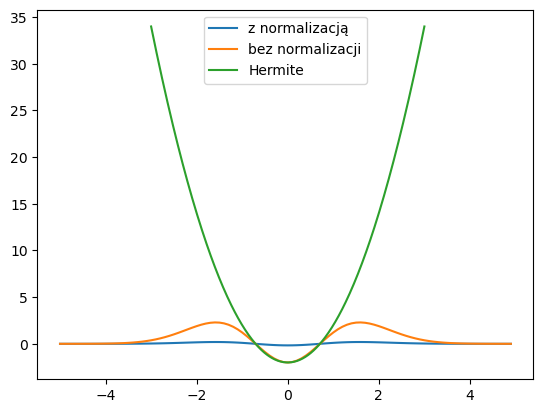

In [11]:
plt.plot(xx,base_fun(xx,2))
plt.plot(xx,base_fun(xx,2,False))
plt.plot(x, Polynomial(hermite.herm2poly([0,0,1]))(x))
plt.legend(["z normalizacją",'bez normalizacji','Hermite'])

#### Krok 2.

Obliczamy wektory wartości dla punktów w `xx` dla kilku kolejnych funkcji bazowych.

In [12]:
base = np.array([base_fun(xx,k) for k in range(4)])
base

array([[ 8.85179827e-07,  1.45213595e-06,  2.35852292e-06,
         3.79253833e-06,  6.03777484e-06,  9.51657999e-06,
         1.48505298e-05,  2.29435199e-05,  3.50941883e-05,
         5.31456119e-05,  7.96813487e-05,  1.18277734e-04,
         1.73822652e-04,  2.52910467e-04,  3.64321070e-04,
         5.19587662e-04,  7.33652542e-04,  1.02560252e-03,
         1.41946531e-03,  1.94503556e-03,  2.63868388e-03,
         3.54408587e-03,  4.71279081e-03,  6.20453366e-03,
         8.08718137e-03,  1.04361972e-02,  1.33335079e-02,
         1.68656711e-02,  2.11212631e-02,  2.61874493e-02,
         3.21457504e-02,  3.90670836e-02,  4.70062354e-02,
         5.59960001e-02,  6.60412972e-02,  7.71136464e-02,
         8.91464266e-02,  1.02031364e-01,  1.15616683e-01,
         1.29707285e-01,  1.44067258e-01,  1.58424836e-01,
         1.72479823e-01,  1.85913267e-01,  1.98399021e-01,
         2.09616624e-01,  2.19264828e-01,  2.27074978e-01,
         2.32823408e-01,  2.36342083e-01,  2.37526753e-0

Sprawdźmy czy otrzymana w ten sposób baza jest ortonormalna (uwaga: zamiast liczyć całkę, liczymy po prostu iloczyn skalarny wektorów wartości. Jeśli wartości są wystarczająco "gęsto" jest do dobre przybliżenie).

In [13]:
dot_base = np.array([x.dot(y).round(5) for x in base for y in base]).reshape(4,4)
print(dot_base)

[[ 1. -0. -0. -0.]
 [-0.  1. -0. -0.]
 [-0. -0.  1. -0.]
 [-0. -0. -0.  1.]]


#### Krok 3.

Obliczamy kolejne współczynniki aproksymacji. Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funkcji aproksymowanej oraz  wektora bazowego (analogia: rzut  wektora wartości funkcji aproksymowanej w kierunku wektora bazowego).

Wektory bazowe są znormalizowane, co upraszcza obliczenia.

In [14]:
coeffs = np.array([yy.dot(f) for f in base])
coeffs

array([ 5.71083178, -0.91010432,  2.64375507, -0.83802114])

Liczymy wartości aproksymowane kolejnymi stopniami

In [15]:
y_app = np.array([coeffs[k]*base[k] for k in range(4)])
y_app_c = np.cumsum(y_app,axis=0)

y_app_c

array([[ 5.05511308e-06,  8.29290411e-06,  1.34691276e-05,
         2.16585484e-05,  3.44807164e-05,  5.43475874e-05,
         8.48088774e-05,  1.31026583e-04,  2.00417005e-04,
         3.03505649e-04,  4.55046778e-04,  6.75464244e-04,
         9.92671926e-04,  1.44432913e-03,  2.08057634e-03,
         2.96727773e-03,  4.18976625e-03,  5.85704344e-03,
         8.10632762e-03,  1.11077709e-02,  1.50690797e-02,
         2.02396782e-02,  2.69139555e-02,  3.54330480e-02,
         4.61845323e-02,  5.95993665e-02,  7.61454208e-02,
         9.63170105e-02,  1.20619980e-01,  1.49552118e-01,
         1.83578973e-01,  2.23105542e-01,  2.68444703e-01,
         3.19783737e-01,  3.77150738e-01,  4.40383062e-01,
         5.09100246e-01,  5.82683958e-01,  6.60267426e-01,
         7.40736487e-01,  8.22743876e-01,  9.04737588e-01,
         9.85003253e-01,  1.06171940e+00,  1.13302343e+00,
         1.19708528e+00,  1.25218455e+00,  1.29678700e+00,
         1.32961532e+00,  1.34970988e+00,  1.35647533e+0

In [ ]:
plt.scatter(xx,yy)
plt.plot(xx,y_app_c[0])
plt.plot(xx,y_app_c[1])
plt.plot(xx,y_app_c[2])
plt.plot(xx,y_app_c[3])
plt.legend(['cos','k=0','k=1','k=2','k=3'])

Liczymy błędy aproksymacji kolejnymi stopniami

In [ ]:
from sklearn.metrics import mean_squared_error as mse

for k in range(4):
    print(f'MSE dla k={k+1} wynosi {mse(yy,y_app_c[k])}')


### EKG

Dane pochodzą z bazy https://www.physionet.org/content/mitdb/1.0.0/ .

W sygnale można wyróżnić wiele struktur, z których najbardziej charakterystyczną jest zespół QRS.

In [ ]:
import pandas as pd

ekg_data = pd.read_csv("ecg_data.csv",sep=';')
ekg_data

In [ ]:
ekg_data.plot('time',['signalN','signalV'])

Uwaga: Funkcje bazowe mają pewną "szerokość" i najlepiej aproksymują inne funkcje o podobnej szerokości. Można dodatkowo sparametryzować f. bazowe aby były węższe i lepiej pasowały do zespołów QRS. Na potrzeby laboratorium postąpimy inaczej - przeskalujemy oś X aproksymowanych sygnałów.

In [ ]:
# Definicja węzłów
xx_ekg = np.array(ekg_data['time']*40)
yy_ekgV = np.array(ekg_data['signalV'])

## Zadania

#### Zadanie 1 (1 pkt)

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2) $H_m(x)$, $m \in \{0,1,...,5\}$

Podobnie  narysować 6 pierwszych funkcji bazowych z uwzględnieniem czynnika wagowego $H_m(x)\exp(-\frac{x^2}{2})$, $m \in \{0,1,...,5\}$

#### Zadanie 2 (1 pkt)

Pokazać, że same wielomiany nie są ortogonane, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

#### Zadanie 3  (1 pkt)

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

#### Zadanie 4  (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?